In [129]:
import numpy as np
import os
import pandas as pd
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from PyALE import ale
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor
import math

In [93]:
# Incorporate data
df_og = pd.read_csv('C:\\Users\\nidhi\\Documents\\team_season_stats.csv')
df = df_og.copy(deep=True)

## Create NBA Offense ratings column

In [83]:
teams = df['TEAM_NAME'].unique()
seasons = df['SEASON_2'].unique()
total_length = len(teams)*len(seasons)
season_col = []
team_col = []
for i in range(0,len(seasons)):
    for j in range(0,len(teams)):
        team_col.append(teams[j])
        season_col.append(seasons[i])
df_new = pd.DataFrame({'Season':season_col,
                     'Team': team_col})
display(df_new)

,Season,Team
0,2003-04,Atlanta Hawks
1,2003-04,Boston Celtics
2,2003-04,Brooklyn Nets
3,2003-04,Charlotte Bobcats
4,2003-04,Charlotte Hornets
...,...,...
715,2022-23,San Antonio Spurs
716,2022-23,Seattle SuperSonics
717,2022-23,Toronto Raptors
718,2022-23,Utah Jazz


In [84]:
df_new.to_excel("C:\\Users\\nidhi\\Documents\\Offensive ratings V2.xlsx") 

In [91]:
offense_ratings_df = pd.read_csv("C:\\Users\\nidhi\\Downloads\\Offensive ratings filled out(Sheet1).csv")
offense_ratings_df = offense_ratings_df.drop(['Unnamed: 0', 'Unnamed: 3'], axis=1)
offense_ratings_df = offense_ratings_df.rename(columns = {'Unnamed: 4':'Offense ratings'})
display(offense_ratings_df)

,Season,Team,Offense ratings
0,2003-04,Atlanta Hawks,99.1
1,2003-04,Boston Celtics,100.7
2,2003-04,Brooklyn Nets,NaN
3,2003-04,Charlotte Bobcats,NaN
4,2003-04,Charlotte Hornets,NaN
...,...,...,...
715,2022-23,San Antonio Spurs,109.7
716,2022-23,Seattle SuperSonics,NaN
717,2022-23,Toronto Raptors,114.6
718,2022-23,Utah Jazz,115.3


In [104]:
offrts = []
start_index = 0 
for i in range(0,len(df['TEAM_NAME'])):
    for j in range(0, len(offense_ratings_df['Season'])):
        if (df['TEAM_NAME'][i]==offense_ratings_df['Team'][j] and df['SEASON_2'][i] == offense_ratings_df['Season'][j]):
            if math.isnan(offense_ratings_df['Offense ratings'][j]) == False:
                offrts.append(offense_ratings_df['Offense ratings'][j])
            else:
                offrts.append(float('nan'))
                

In [114]:
df['Offensive rating'] = offrts
df = df.drop(['TEAM_ID', 'preferred_shot_zone'], axis=1)
df = df.replace(['Charlotte Bobcats', 'Los Angeles Clippers', 'New Orleans Hornets'], ['Charlotte Hornets', 'LA Clippers', 'New Orleans Pelicans'])
#df.to_csv("C:\\Users\\nidhi\\Documents\\Team stats complete incl offrts.xlsx") 

C:\Users\nidhi\AppData\Local\Temp\ipykernel_6656\3475902879.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Offensive rating'][71] = 105.8


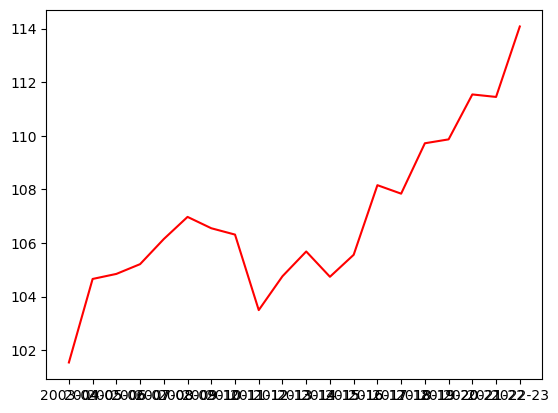

In [125]:
df['Offensive rating'][71] = 105.8
mean_of_seasons = df.groupby(['SEASON_2']).mean()['Offensive rating']
plt.plot(mean_of_seasons, color = 'r')
plt.show()

In [1]:
encoded_data = pd.get_dummies(df.dropna(), columns = ['SEASON_2'])

NameError: name 'pd' is not defined

## Random forest model

In [136]:
#Independent variables X and dependent variable y
X = encoded_data.drop(['TEAM_NAME', 'Offensive rating'], axis=1)
y = encoded_data['Offensive rating']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [137]:
#Define the Random Forest model
rf = RandomForestRegressor()

# Define the parameter grid to search
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

#Create the GridSearchCV object
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, scoring='neg_mean_squared_error', cv=5)

#Fit the grid search to the data
grid_search_rf.fit(X_train, y_train)

#Print the best parameters and corresponding score
print("Best Parameters:", grid_search_rf.best_params_)
print("Best Negative Mean Squared Error:", grid_search_rf.best_score_)

#Get the best model
best_rf = grid_search_rf.best_estimator_

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Negative Mean Squared Error: -3.688545589453222


In [140]:
import joblib

# save
#joblib.dump(grid_search_rf, "C:\\Users\\nidhi\\Documents\\VA RF.joblib")

['C:\\Users\\nidhi\\Documents\\VA RF.joblib']

In [142]:
#Evaluate the best model on the test set
y_pred_rf = best_rf.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f'Mean Squared Error on Test Set: {mse_rf}')

Mean Squared Error on Test Set: 4.1376207948718156


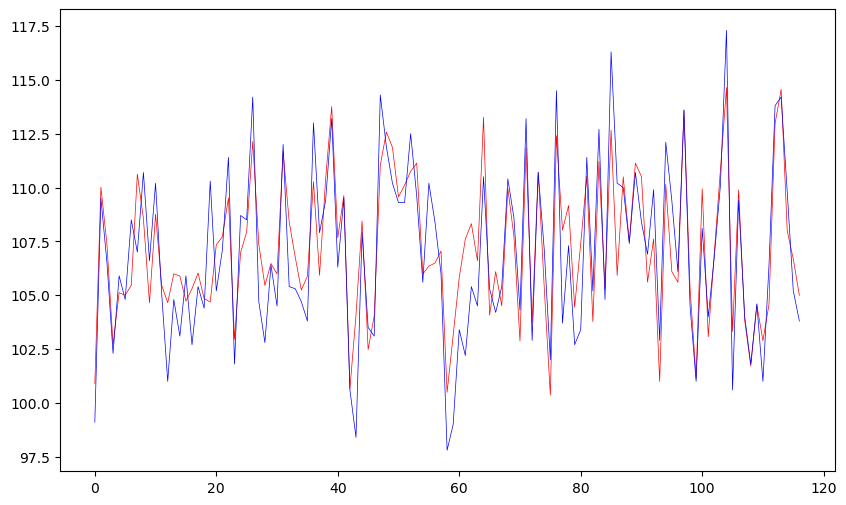

In [170]:
plt.figure(figsize=(10,6))
plt.plot(y_pred_rf, color='r', linewidth=0.5)
plt.plot(y_test.reset_index()['Offensive rating'], color='b', linewidth=0.5)
plt.show()

In [156]:
#Obtain the permuted feature importances of all features
r = permutation_importance(best_rf, X_test, y_test, n_repeats=10, random_state=0, scoring='neg_mean_squared_error')
r.importances_mean

array([ 3.26099475e-01, -7.54149487e-03, -1.46589060e-03,  7.99794333e-02,
        4.81950375e+00,  1.10059049e-01,  1.10362545e-01, -1.45518325e-02,
        4.23069428e+00,  3.01420120e+00,  4.49950427e-03,  2.63284538e-02,
        1.48582077e-02,  3.33010444e-02,  2.73908632e-03,  2.95056325e-03,
       -8.28348291e-03,  4.64452222e-03,  3.31391709e-03,  4.64353248e-03,
        1.28312026e-02, -5.34933419e-03,  1.27079145e-03, -7.86402564e-04,
        2.61764735e-02, -5.39805214e-03,  2.30757521e-03, -1.88468188e-02,
       -3.21207692e-03, -2.46503419e-04])

<AxesSubplot:ylabel='Feature'>

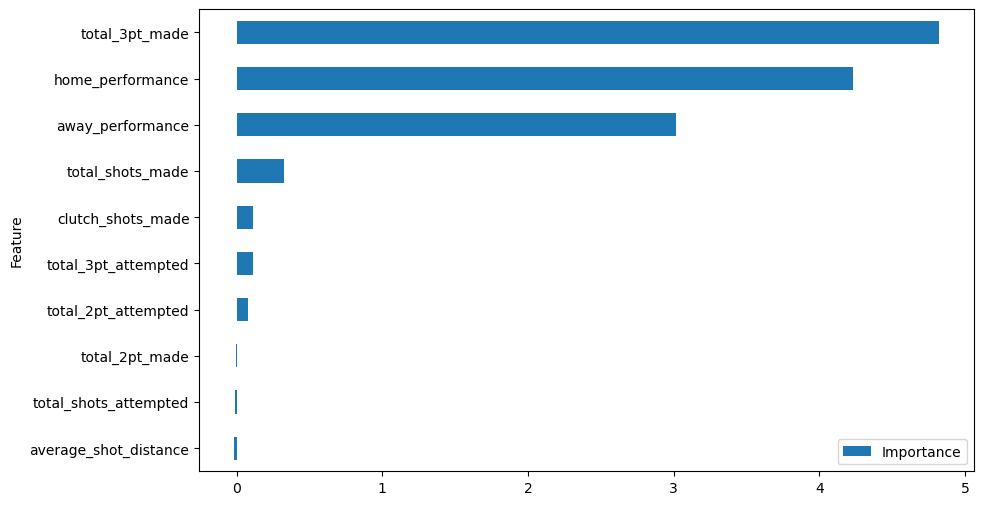

In [164]:
#Plot the feature importance plot
feature_importance = pd.DataFrame({'Feature': X.columns[0:10], 'Importance': r.importances_mean[0:10]})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

PyALE._ALE_generic:INFO: Continuous feature detected.


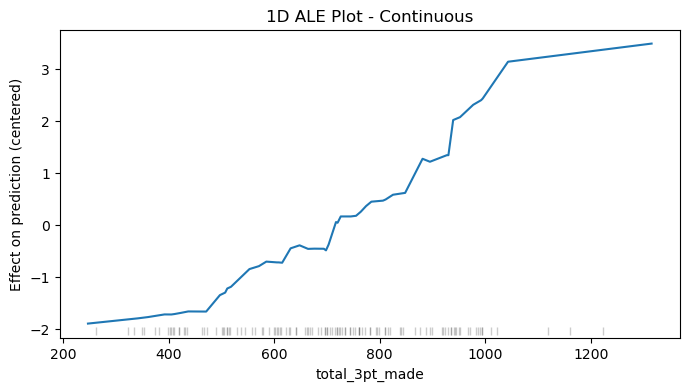

In [174]:
#Obtain the ALE plots for the most important features
ale_eff = ale(X=X_test, model=best_rf, feature=["total_3pt_made"], grid_size=50, include_CI=False)

PyALE._ALE_generic:INFO: Continuous feature detected.


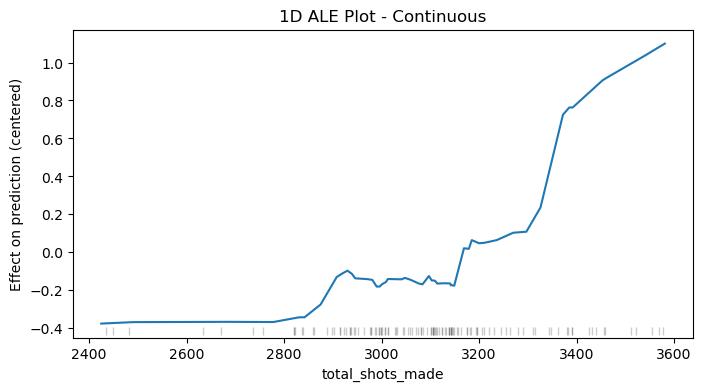

In [172]:
ale_eff = ale(X=X_test, model=best_rf, feature=["total_shots_made"], grid_size=50, include_CI=False)